# 本次栈变量净生分析结论: 栈变量净生仅剩2.5%

- 上回结论：到程序结束时，栈变量 生24万、死22万、  净生2万，   即约10%的不平衡性

- 本回结论：到程序结束时，栈变量 生24万、死23.5万、净生0.5万，即**约2.5%的不平衡性, 较上次有实质性提升**。

# 产生滴答日志过程介绍



###### 1. 用 已正常工作的 clang加花括号插件libBrcPlugin.so 对目标物品llvm-project 加花括号
> [clang-plugin-add-brace/a5e9c786ec81de511c6a134684509b8d09a36091](http://localhost:10880/analyze_code/clang-plugin-add-brace/commit/a5e9c786ec81de511c6a134684509b8d09a36091)


```bash
# 用libBrcPlugin.so在编译过程中对源码加花括号
bash -x /pubx/llvm-project/doc_clang15_build/brc_build1_plugin.sh

#加花括号后源码为: https://gitcode.net/pubz/llvm-project/-/commit/161888dca45b61a745605d632a6e90d8ea9cb5ec

# 再次编译已经加花括号的源码，
#   编译成功、且编译产物clang-15能正常使用, 即验证了 加花括号 是 成功的，因为其没有影响clang正常功能。
bash -x /pubx/llvm-project/doc_clang15_build/brc_build2_directly.sh
```




###### 2. 获得已加花括号的目标物品llvm-project
> [llvm-project/161888dca45b61a745605d632a6e90d8ea9cb5ec](https://gitcode.net/pubz/llvm-project/-/commit/161888dca45b61a745605d632a6e90d8ea9cb5ec)
>
> 注意这个提交信息写错了，写成 'tick:...'了，应该写为'braced:...', 不过提交内容是没问题的



###### 3. 用 已经正常工作的 clang滴答插件libCTk.so 对已加花括号的目标物品llvm-project 加滴答语句
>[clang-ctk/9c913ca6348531db8191b4819967f9e68cc1030e](http://localhost:10880/analyze_code/clang-ctk/commit/9c913ca6348531db8191b4819967f9e68cc1030e)

```bash
# 用libCTk.so在编译过程中对源码加滴答语句
bash -x /pubx/llvm-project/doc_clang15_build/tick_build1_plugin.sh

#加滴答语句后源码为: llvm-project/-/commit/c8806b68ae44a5eb93ddd6e32e07fbfe0bc603b3  ，为了保密， 此源码不推送

# 再次编译已经加滴答语句的源码，
#  编译成功、且编译产物clang-15能正常使用, 即验证了 加滴答语句 是 成功的，因为其没有影响clang正常功能。
bash -x /pubx/llvm-project/doc_clang15_build/tick_build2_directly.sh
```

> 罗嗦一下， **编译 已加滴答语句后源码 获得 产物clang-15，运行该产物clang-15, 产生滴答日志，供本文分析**
>
>  此滴答文件如下:
```bash
tick_save=true /pubx/build-llvm15/bin/clang-15 -c mini_main.c
ls -lhrt /tick_data_home/
#-rw-rw-r-- 1 zz zz 138M  8月  8 22:23 clang-15_960162_1691504630415_1  #下面就是对此滴答日志进行简单作图


```

###### 4. 获得已加滴答语句的目标物品llvm-project
> 由于保密原因，此提交不能推送: llvm-project/-/commit/c8806b68ae44a5eb93ddd6e32e07fbfe0bc603b3  

#  0. 用matplotlib找系统中字体文件大于1MB的
> 中文字体通常很大，这样过滤出的 通常有中文字体

> 结果中 看名字  'AR PL UMing CN' 果然是中文字体

In [1]:
from matplotlib.font_manager import fontManager
import os
 
fonts = [font.name for font in fontManager.ttflist if 
         os.path.exists(font.fname) and os.stat(font.fname).st_size>1e6] 
 
for font in fonts:
    print(font)

Peddana
TenaliRamakrishna
Noto Serif CJK JP
Noto Sans CJK JP
Noto Serif Tangut
Noto Serif CJK JP
Chandas
AR PL UMing CN
Noto Serif CJK JP
Noto Sans CJK JP
Noto Sans CJK JP
Noto Sans CJK JP
Droid Sans Fallback
Noto Sans CJK JP
Noto Sans SignWriting
FreeSerif
AR PL UKai CN
Noto Serif CJK JP
Timmana
Noto Serif CJK JP
Noto Serif CJK JP
Noto Serif CJK JP
Noto Sans CJK JP
Noto Sans CJK JP
Tibetan Machine Uni


#  1. 产生tick日志

#####  编译最小main : 文件 mini_main.c
```cpp
//文件 mini_main.c
int main(int argc, char** argv){
    return 0;
}
```

```bash
tick_save=true /pubx/build-llvm15/bin/clang-15 -c mini_main.c
#生成tick日志文件:
#-rw-rw-r--  138M  8月  8 22:23 clang-15_960162_1691504630415_1
```

# 2. 加载tick日志

In [2]:
# %config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc={'figure.figsize': (30,20)}

> 

In [3]:
import numpy 
import math

In [4]:
import seaborn

In [5]:
import plotly.offline as plotly_offline
plotly_offline.init_notebook_mode(connected=True)          
import plotly.graph_objs as graph_objs                
import plotly.figure_factory as figure_factory 

from plotly.graph_objs import Scatter, Figure, Scatter3d




> 解决 matplotlib 中文不正常显示问题，
>
> 中文显示为方块，原因是没有中文字体，
>
> 这里 将字体设置为 上面找到的中文字体 'AR PL UMing CN'

In [6]:
import matplotlib.pyplot
matplotlib.pyplot.rcParams['font.family'] = 'AR PL UMing CN'
matplotlib.pyplot.rcParams['font.sans-serif'] = [ 'AR PL UMing CN']

In [7]:
import pandas
# pandas.options.display.max_columns = None
# pandas.options.display.max_rows = None

In [8]:
%%bash
ls -lhrt /tick_data_home/ | tail -n 1

-rw-rw-r-- 1 zz zz 138M  8月  8 22:23 clang-15_960162_1691504630415_1


In [9]:
#编译正常: mini_main.c
df_mini_main=pandas.read_csv(filepath_or_buffer="/tick_data_home/clang-15_960162_1691504630415_1",sep=',' , quotechar="'")

df_mini_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014494 entries, 0 to 1014493
Data columns (total 18 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   滴答           1014494 non-null  int64 
 1   tickKind     1014494 non-null  int64 
 2   funcEnterId  1014494 non-null  int64 
 3   rTSVarC      1014494 non-null  int64 
 4   d栈生          1014494 non-null  int64 
 5   d栈死          1014494 non-null  int64 
 6   d堆生          1014494 non-null  int64 
 7   d堆死          1014494 non-null  int64 
 8   栈生           1014494 non-null  int64 
 9   栈死           1014494 non-null  int64 
 10  栈净           1014494 non-null  int64 
 11  堆生           1014494 non-null  int64 
 12  堆死           1014494 non-null  int64 
 13  堆净           1014494 non-null  int64 
 14  srcFile      1014494 non-null  object
 15  funcLine     1014494 non-null  int64 
 16  funcCol      1014494 non-null  int64 
 17  funcName     1003994 non-null  object
dtypes: int64(16), object(2

> 文件: /pubx/clang-ctk/t_clock_tick/t_clock_tick.cpp
```cpp
/**滴答种类
 *需要被正常分析的tick是 正常tick 和 函数返回tick，
 * 正常分析不需要 函数进入tick
 * 看哪里少插入了X__funcReturn: 比对 函数进入tick    和  函数返回tick 是否配对
 */
enum TickKind{
    //正常tick
    NormalTick=0,
    //函数进入tick 可作为 和 函数返回tick 做比对，看哪里少插入了X__funcReturn
    FuncEnter=1,
    //函数返回tick
    FuncReturn=2

};
```

In [10]:
NormalTick=0
#函数进入
FuncEnter=1
#函数返回tick
FuncReturn=2
    
#TOdo 只保留 进入和返回

df_mini_main=df_mini_main[  df_mini_main['tickKind'].isin( [FuncEnter,FuncReturn] )  ]

In [11]:
df_mini_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241939 entries, 0 to 1014493
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   滴答           241939 non-null  int64 
 1   tickKind     241939 non-null  int64 
 2   funcEnterId  241939 non-null  int64 
 3   rTSVarC      241939 non-null  int64 
 4   d栈生          241939 non-null  int64 
 5   d栈死          241939 non-null  int64 
 6   d堆生          241939 non-null  int64 
 7   d堆死          241939 non-null  int64 
 8   栈生           241939 non-null  int64 
 9   栈死           241939 non-null  int64 
 10  栈净           241939 non-null  int64 
 11  堆生           241939 non-null  int64 
 12  堆死           241939 non-null  int64 
 13  堆净           241939 non-null  int64 
 14  srcFile      241939 non-null  object
 15  funcLine     241939 non-null  int64 
 16  funcCol      241939 non-null  int64 
 17  funcName     232324 non-null  object
dtypes: int64(16), object(2)
memory usage: 35.1+

In [12]:
df_mini_main.tail(5)

,滴答,tickKind,funcEnterId,rTSVarC,d栈生,d栈死,d堆生,d堆死,栈生,栈死,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName
1014485,1012458,1,122003,0,0,0,0,0,239875,235690,4185,0,0,0,/pubx/llvm-project/llvm/lib/Support/PrettyStac...,227,49,llvm::PrettyStackTraceEntry::~PrettyStackTrace...
1014488,1012461,1,122004,0,0,0,0,0,239875,235690,4185,0,0,0,/pubx/llvm-project/llvm/lib/Support/PrettyStac...,195,39,printForSigInfoIfNeeded
1014491,1012464,2,122004,1,0,1,0,0,239876,235690,4186,0,0,0,/pubx/llvm-project/llvm/lib/Support/PrettyStac...,195,39,printForSigInfoIfNeeded
1014492,1012465,2,122003,0,0,0,0,0,239876,235691,4185,0,0,0,/pubx/llvm-project/llvm/lib/Support/PrettyStac...,227,49,llvm::PrettyStackTraceEntry::~PrettyStackTrace...
1014493,1011967,1,121841,0,0,0,0,0,239875,235690,4185,0,0,0,/pubx/llvm-project/llvm/lib/Support/MemAlloc.cpp,24,72,llvm::deallocate_buffer


In [13]:

dfmm=df_mini_main

In [14]:
dfmm.shape,  df_mini_main.shape

((241939, 18), (241939, 18))

# 3. funcId 构造

In [15]:
dfmm.head(1)

,滴答,tickKind,funcEnterId,rTSVarC,d栈生,d栈死,d堆生,d堆死,栈生,栈死,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2603,42,llvm::cl::getGeneralCategory


####  3.1 新增列 funcLoc  相当于字符串样式的funId

In [16]:
#新增列 funcLoc 
dfmm['funcLoc']=dfmm .apply(lambda r: f'{r.srcFile}_{r.funcLine}_{r.funcCol}', axis=1 )
dfmm['funcLoc'].values[:4]

array(['/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_2603_42',
       '/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_480_41',
       '/pubx/llvm-project/llvm/lib/Support/ManagedStatic.cpp_28_77',
       '/pubx/llvm-project/llvm/lib/Support/Threading.cpp_31_36'],
      dtype=object)

####  3.2  以 区间[0, funcLoc不重复个数-1] 作为 funcId表

In [17]:

funcLoc_values=dfmm['funcLoc'].values
type(funcLoc_values)#numpy.ndarray
len(funcLoc_values)#1014494

funcLoc_list=list(funcLoc_values)
len(funcLoc_list)#1014494

#funcLoc转为集合
funcLoc_set=set(funcLoc_values)
len(funcLoc_set)#2838

#funcLoc集合作为列表: 即 不重复的funcLoc 列表
uqFuncLoc_Ls=list(funcLoc_set)
len(uqFuncLoc_Ls)#2838
#uq:unique

#不重复的funcLoc 列表 转为 funcId表
funcId_Tab=dict( [(fL,j) for j,fL in enumerate(uqFuncLoc_Ls)] )
list(funcId_Tab.items())[:5]

[('/pubx/llvm-project/clang/lib/Driver/ToolChains/Gnu.cpp_2986_72', 0),
 ('/pubx/llvm-project/clang/lib/Sema/IdentifierResolver.cpp_232_49', 1),
 ('/pubx/llvm-project/llvm/lib/MC/MCStreamer.cpp_117_67', 2),
 ('/pubx/llvm-project/llvm/lib/Support/SmallPtrSet.cpp_182_63', 3),
 ('/pubx/llvm-project/llvm/lib/IR/BasicBlock.cpp_477_63', 4)]

In [18]:
print("funcId个数:",len(funcId_Tab))

funcId个数: 2837


####  3.3  参照 funLoc列、funcId表 新增列funcId

In [19]:
#新增列 funcId 
dfmm['funcId']=dfmm['funcLoc'] .apply(lambda fLocJ:  funcId_Tab[fLocJ] )
dfmm['funcId'].values[:10]
dfmm.head(2)

,滴答,tickKind,funcEnterId,rTSVarC,d栈生,d栈死,d堆生,d堆死,栈生,栈死,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName,funcLoc,funcId
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2603,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,1207
2,3,1,1,0,0,0,0,0,1,0,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,480,41,llvm::cl::OptionCategory::registerCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2112


####  3.x  开发用代码

In [20]:
#

# 4. 按funcId分组、组内行数降序

### 4.1 按funcId分组、组内行数降序

In [21]:
各funcId的调用次数 = dfmm.groupby('funcId').size().reset_index(name='count')

各funcId的调用次数降序 = 各funcId的调用次数.sort_values(by='count', ascending=False)
各funcId的调用次数降序.head(5)

,funcId,count
1701,1701,19250
2393,2393,18774
1968,1968,11224
2668,2668,11092
2476,2476,8822


In [22]:
# 按 funcId,funcName 分组.   
#   一个funcId 对应 多个funcName，因此funcName是冗余列，只是为了组内能看到funcName的值
各funcId名的调用次数 = dfmm.groupby(['funcId','funcName']).size().reset_index(name='count')

各funcId名的调用次数_降序 = 各funcId名的调用次数.sort_values(by='count', ascending=False)
各funcId名的调用次数_降序[:5]

,funcId,funcName,count
1667,1701,getHashTable,19250
2347,2393,llvm::StringMapImpl::LookupBucketFor,18774
1931,1968,llvm::StringMapImpl::RehashTable,11224
2617,2668,optionMatches,11092
292,301,clang::LangOptions::getOpenCLCompatibleVersion,6526


In [23]:
各funcId名的调用次数_降序.funcId.values[:5]

array([1701, 2393, 1968, 2668,  301])

### 4.2 

In [24]:
# 按列 'funcId' 分组, 组内按列 '滴答' 升序排序
# 各funcId = dfmm.groupby('funcId').apply(lambda x: x.sort_values('滴答')).reset_index(drop=True)

# 按列 'funcId' 分组, 保留组内行数大于1的组， 组内按列 '滴答' 升序排序
各funcId = dfmm.groupby('funcId').filter(lambda x: len(x)>1).sort_values('滴答').reset_index(drop=True)

# 组内相邻行之间的 '滴答' 列的差值
各funcId['滴答差值'] = 各funcId.groupby('funcId')['滴答'].diff()

# 保留每个组的最大差值
相邻同funcId间隔时长最大 = 各funcId.groupby('funcId')['滴答差值'].max().reset_index()
相邻同funcId间隔时长最大_降序=相邻同funcId间隔时长最大.sort_values(by='滴答差值', ascending=False)


In [25]:
相邻同funcId间隔时长最大_降序[:5]

,funcId,滴答差值
1127,1141,927897.0
1678,1699,809873.0
956,966,789094.0
2029,2054,781859.0
1013,1024,778499.0


In [26]:
各funcId名的调用次数_降序[:5]

,funcId,funcName,count
1667,1701,getHashTable,19250
2347,2393,llvm::StringMapImpl::LookupBucketFor,18774
1931,1968,llvm::StringMapImpl::RehashTable,11224
2617,2668,optionMatches,11092
292,301,clang::LangOptions::getOpenCLCompatibleVersion,6526


In [27]:
N=100
相邻同funcId间隔时长最大_降序[:N].funcId.values,  各funcId名的调用次数_降序[-N:].funcId.values

(array([1141, 1699,  966, 2054, 1024,  175, 2392, 1598, 2600,   73, 2264,
        2549, 2368, 1831, 2034, 2010, 2542,  793,  536, 1130,  325, 1031,
        2206,  357, 2593, 1760,  353,  892, 1006,  519, 1985, 2012, 1118,
        1971,  383,  767, 1834, 2405,  199,  292, 2404, 1614, 2177,  839,
          50, 2211, 2203,  732, 1548, 2008,  380,  997, 2701, 2507,  677,
        1837, 2444,  807, 1918,  852,  156,  470,  946, 2725, 1127, 1573,
        1896,   17, 2126,  854,  810, 1005,  723, 1049, 1089, 2443,   29,
        2100, 2367,  114, 2486, 2304, 2455, 1515, 1328, 1019, 1588, 2490,
        1592, 2805, 1627,  123, 2555, 2070, 1008, 1654, 1708,  669, 1809,
        2014]),
 array([1370, 1366, 1372, 1363, 1359, 1358, 1354, 1353, 1351, 1373, 1349,
        1381, 1346, 1344, 1339, 1375, 1376, 1336, 1331, 1330, 1377, 1379,
        1284, 1282, 1242, 1222, 1240, 1236, 1231, 1393, 1230, 1229, 1228,
        1394, 1226, 1224, 1220, 1279, 1219, 1218, 1217, 1216, 1208, 1206,
        1205, 1397, 12

In [28]:
len( set( [* 相邻同funcId间隔时长最大_降序[:N].funcId.values, * 各funcId名的调用次数_降序[-N:].funcId.values]) )

200

In [29]:
J=min(相邻同funcId间隔时长最大_降序.shape[0], 各funcId名的调用次数_降序.shape[0])

In [30]:
交集尺寸比率们=[]
for j in range(1,J):
    交集j尺寸=len( set( [* 相邻同funcId间隔时长最大_降序[:j].funcId.values, * 各funcId名的调用次数_降序[-j:].funcId.values]) )
    交集尺寸比率们.append(交集j尺寸/(2*j))
    

In [31]:
交集尺寸比率们[-5:]


[0.5091792656587473,
 0.5089960417416337,
 0.5088129496402878,
 0.5086299892125135,
 0.5084471603163192]

<AxesSubplot:>

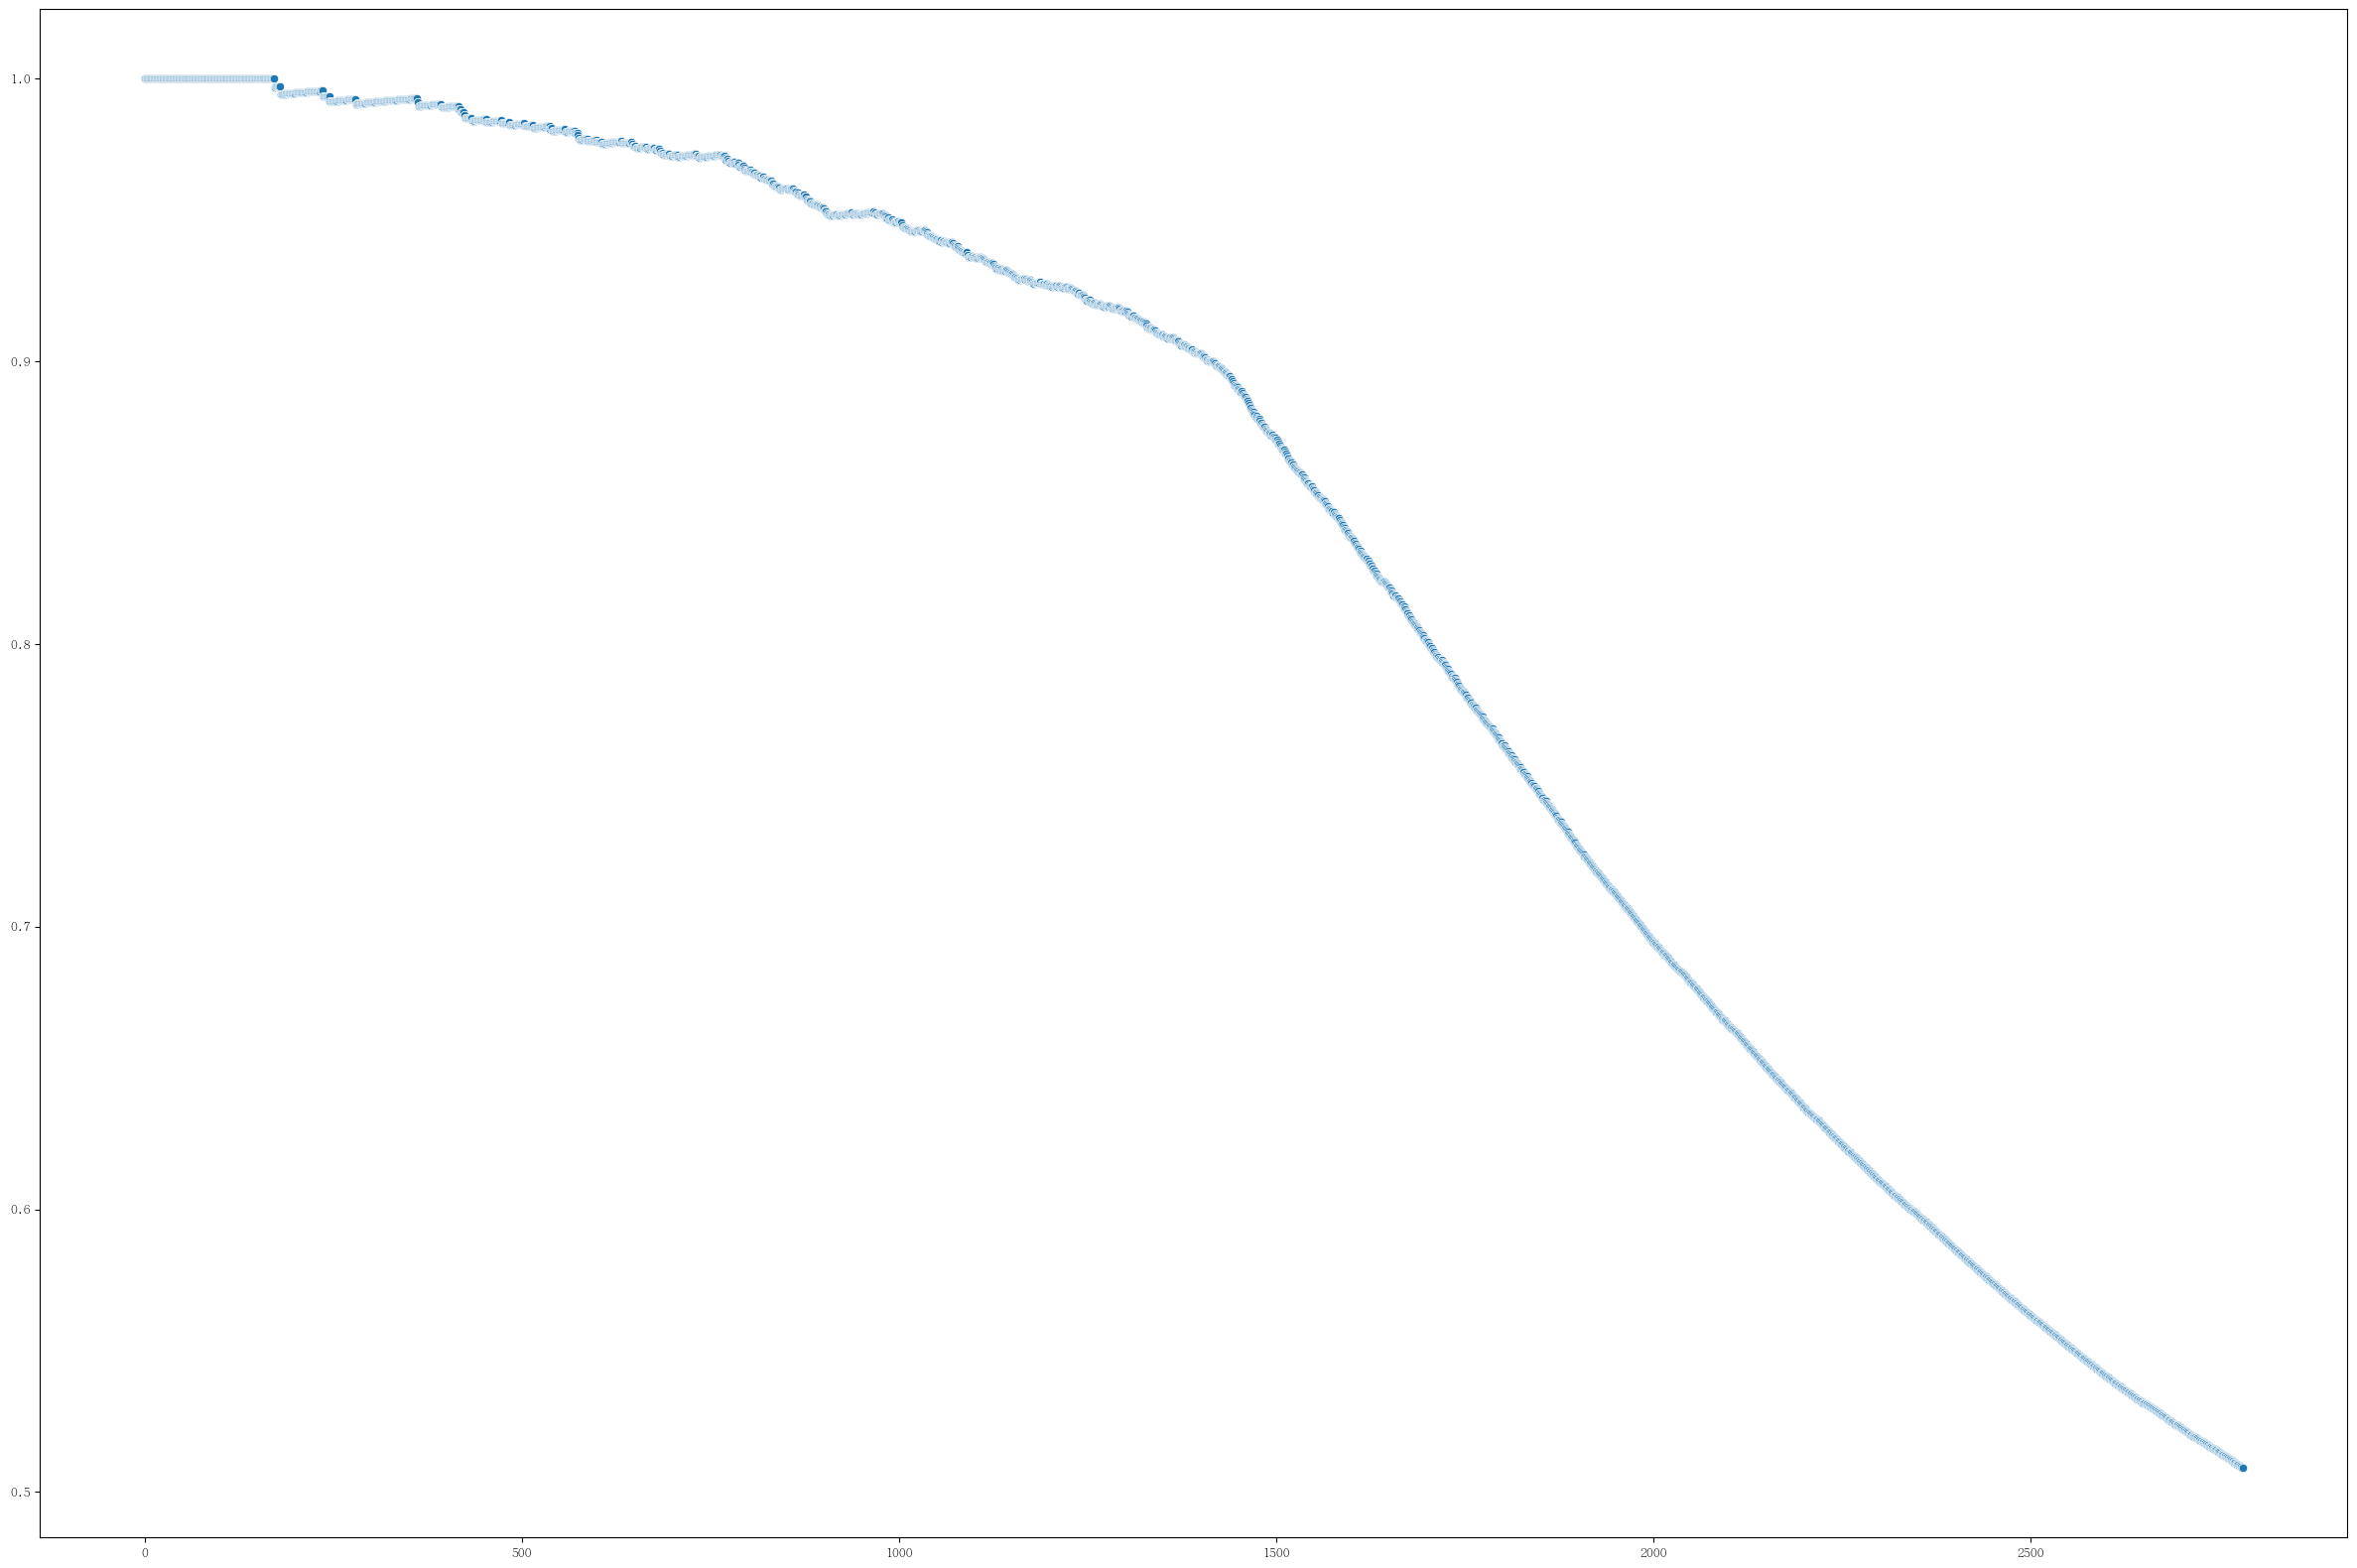

In [32]:
%config InlineBackend.rc={'figure.figsize': (30,20)}

seaborn.scatterplot(x=range(len(交集尺寸比率们)), y=交集尺寸比率们)


In [33]:
交集尺寸比率_trace = graph_objs.Scatter(
 x = list(range(len(交集尺寸比率们))),
 y = 交集尺寸比率们,
 showlegend=True,
mode = 'markers',
marker={'size':2, 'opacity': 0.9},
name="交集尺寸比率"
)

plotly_offline.iplot([ 交集尺寸比率_trace])

### 4.3 plotly作图

### 4.4 plotly交互作图: 给定funcId列表